In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from types import SimpleNamespace
from scipy.optimize import fsolve

from IHANKModel import IHANKModelClass
import figures 
import calculations

In [2]:
new_fig = False

# Expenditure grid 
e_list = np.linspace(0.01, 2.0, 100)

# Colors 
c = {'T': 'r', 'NT': 'b'}

# Parameteres 
# Bohnert et al. 2024
par_bohnert = SimpleNamespace()
par_bohnert.gamma = 0.29
par_bohnert.epsilon = 0.18
par_bohnert.nu = 0.475

# Cubb douglas parameters gamma = epsilon = 0 
par_cd = SimpleNamespace()
par_cd.gamma = 0.00000001
par_cd.epsilon = 0.0000000001
par_cd.nu = 0.475

# non-homothetic CES parameters (gamma = epsilon)
par_ces = SimpleNamespace()
par_ces.gamma = 0.29
par_ces.epsilon = 0.29
par_ces.nu = 0.475 

In [4]:

# Plotting expenditure shares
c = {'T': 'r', 'NT': 'b'}

# Define your functions
def calc_CT(par, e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CT

def calc_CNT(par,e, PT=1, PNT=1):
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CNT

def share_T(par,e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)  
    return CT/(CT+CNT) 

def share_NT(par, e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)  
    return CNT/(CT+CNT)

def exp_shareT(par,e, PT=1, PNT=1):
    omega_T = par.nu *(PNT/e)**par.epsilon*(PT/PNT)**par.gamma
    return omega_T

def exp_shareNT(par,e, PT=1, PNT=1):
    omega_NT = 1-par.nu *(PNT/e)**par.epsilon*(PT/PNT)**par.gamma
    return omega_NT

def utility_indirect(par,e, PT=1, PNT=1):
    utility = (1/par.epsilon) * ( (e/PNT)**par.epsilon -1) - (par.nu/par.gamma)*( (PT/PNT)**par.gamma -1)
    return utility

def mu_e(par,e, PT=1, PNT=1):
    mu_e = PNT**(-par.epsilon) * e**(- (1-par.epsilon))
    return mu_e
    
# mapar.
# nualy calculating mu_e to check if it is correct
def mu_e_maual(par,e, PT=1, PNT=1):
    utility = utility_indirect(e, PT, PNT, par.nu, par.epsilon, par.gamma)
    utility_plus_1 = utility_indirect(e*1.01, PT, PNT, par.nu, par.epsilon, par.gamma)
    mu_e = (utility_plus_1 - utility) / (0.01*e)
    return mu_e

def calc_cost_of_living(par, e, PT=1, PNT=1):

    omega_T = exp_shareT(par, e, PT=1, PNT=1)
    omega_NT = exp_shareNT(par, e, PT=1, PNT=1)
    
    p_tilde = ((1-(par.epsilon*omega_T)/par.gamma)*PNT**par.gamma + ((par.epsilon*omega_T)/par.gamma)*PT**par.gamma)**(1/par.gamma)

    p_index = p_tilde**(par.gamma/par.epsilon)*PNT**(-(par.gamma/par.epsilon))

    return p_index

def calc_cost_of_living_diff(par, e, PT=1, PNT=1):

    p_index = calc_cost_of_living(par, e, PT, PNT)
    pct_change = (p_index - 1)*100    

    return pct_change

# Calculating the non constant elasticity of substitution
def calc_NCES(par, e, PT=1, PNT=1):
    omega_T = exp_shareT(par, e, PT, PNT)
    omega_NT = exp_shareNT(par, e, PT, PNT)

    elasticity = 1- par.gamma - (omega_T/omega_NT)*(par.gamma-par.epsilon)
    
    return elasticity

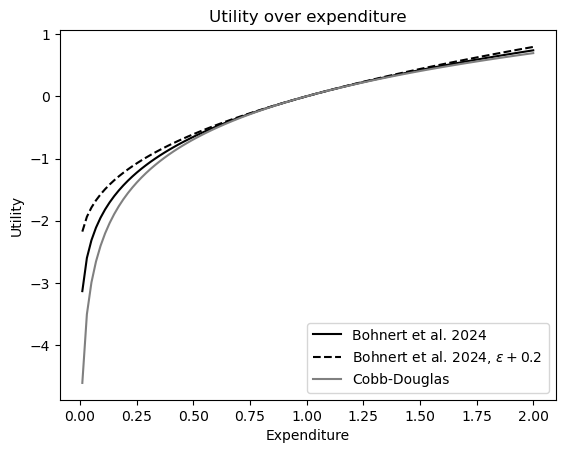

In [4]:
# Intretemporal elisticity of substitution

fig, ax = plt.subplots()#figsize=(12, 8))

# Coppy par borhert
par_bohnert_epsilon_high = SimpleNamespace()
par_bohnert_epsilon_high.gamma = par_bohnert.gamma
par_bohnert_epsilon_high.epsilon = par_bohnert.epsilon + 0.2
par_bohnert_epsilon_high.nu = par_bohnert.nu

# Utility over expenditure
ax.plot(e_list, utility_indirect(par_bohnert, e_list), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, utility_indirect(par_bohnert_epsilon_high, e_list), label='Bohnert et al. 2024, $\epsilon + 0.2 $ ', c='k', linestyle='--')
ax.plot(e_list, utility_indirect(par_cd, e_list), label='Cobb-Douglas', c='grey')

ax.set_xlabel('Expenditure')
ax.set_ylabel('Utility')
ax.legend()
ax.set_title('Utility over expenditure')
if new_fig: plt.savefig('Figures/utility_over_expenditure.png', dpi=300, bbox_inches='tight')

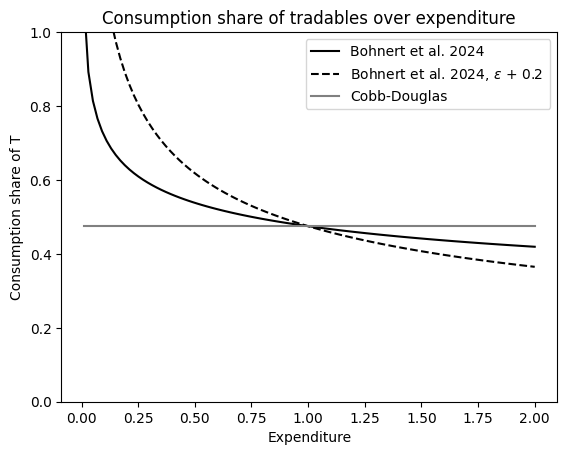

In [13]:
fig, ax = plt.subplots()#figsize=(12, 8))

# Consumption shares over expenditure
ax.plot(e_list, share_T(par_bohnert, e_list), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, share_T(par_bohnert_epsilon_high, e_list), label='Bohnert et al. 2024, $\epsilon$ + 0.2 ', c='k', linestyle='--')
ax.plot(e_list, share_T(par_cd, e_list), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Consumption share of T')
ax.set_title('Consumption share of tradables over expenditure')
ax.legend()
if new_fig: plt.savefig('Figures/consumption_share_T_over_expenditure.png', dpi=300, bbox_inches='tight')

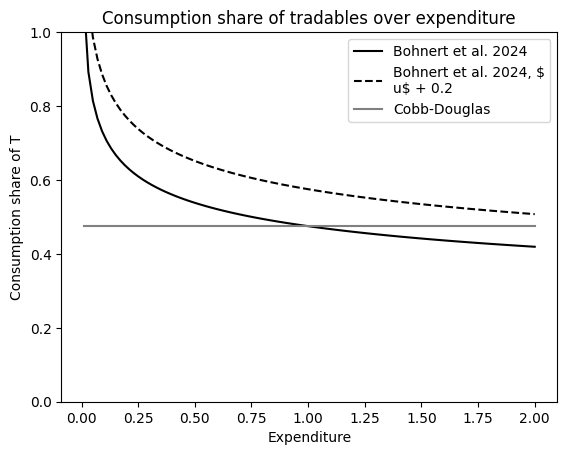

In [14]:
# Nu 

# Coppy par borhert
par_bohnert_nu_high = SimpleNamespace()
par_bohnert_nu_high.gamma = par_bohnert.gamma
par_bohnert_nu_high.epsilon = par_bohnert.epsilon 
par_bohnert_nu_high.nu = par_bohnert.nu + 0.1

fig, ax = plt.subplots()#figsize=(12, 8))

# Consumption shares over expenditure
ax.plot(e_list, share_T(par_bohnert, e_list), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, share_T(par_bohnert_nu_high, e_list), label='Bohnert et al. 2024, $\nu$ + 0.2 ', c='k', linestyle='--')
ax.plot(e_list, share_T(par_cd, e_list), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Consumption share of T')
ax.set_title('Consumption share of tradables over expenditure')
ax.legend()
if new_fig: plt.savefig('Figures/consumption_share_T_over_expenditure.png', dpi=300, bbox_inches='tight')

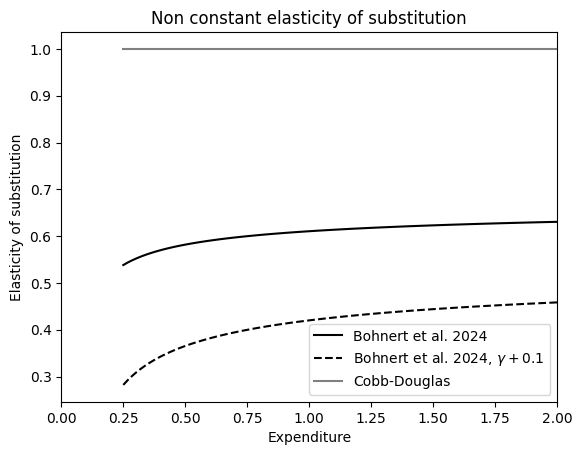

In [15]:
#calc_NCES
# Coppy par borhert
par_bohnert_gamma_high = SimpleNamespace()
par_bohnert_gamma_high.epsilon = par_bohnert.epsilon
par_bohnert_gamma_high.gamma = par_bohnert.gamma + 0.1
par_bohnert_gamma_high.nu = par_bohnert.nu


fig, ax = plt.subplots()#figsize=(12, 8))

# alternative e starting at 0.25
e_alt = np.linspace(0.25, 2.0, 100)
ax.plot(e_alt, calc_NCES(par_bohnert, e_alt), label='Bohnert et al. 2024', c='k')
ax.plot(e_alt, calc_NCES(par_bohnert_gamma_high, e_alt), label='Bohnert et al. 2024, $\gamma + 0.1 $', c='k', linestyle='--')
ax.plot(e_alt, calc_NCES(par_cd, e_alt), label='Cobb-Douglas', c='grey', linestyle='-')

ax.set_xlabel('Expenditure')
ax.set_ylabel('Elasticity of substitution')
ax.legend()
ax.set_xlim(0.0, 2.0)
ax.set_title('Non constant elasticity of substitution')
if new_fig: plt.savefig('Figures/elicitcity_of_substitution.png', dpi=300, bbox_inches='tight')

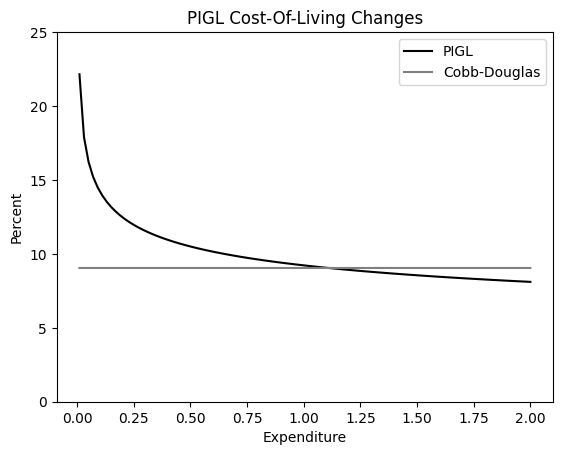

In [16]:
# Plotting IPP
#par_bohnert_epsilon_high.epsilon = par_bohnert.epsilon + 0.2
fig, ax = plt.subplots()#figsize=(12, 8))
ax.plot(e_list, calc_cost_of_living_diff(par_bohnert, e_list, PT = 1.2), label='PIGL', c='k')
ax.plot(e_list, calc_cost_of_living_diff(par_cd, e_list, PT = 1.2), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_title('PIGL Cost-Of-Living Changes')
ax.set_ylabel('Percent')
ax.set_ylim(0,25)
ax.legend()
if new_fig: plt.savefig('Figures/cost_of_living.png', dpi=300, bbox_inches='tight')

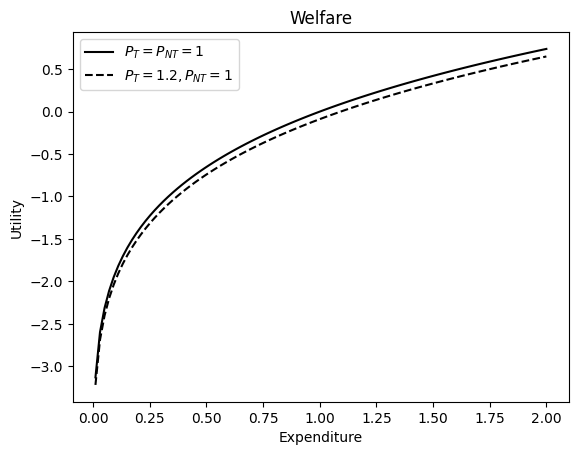

In [17]:
#Welfare change utility_indirect
fig, ax = plt.subplots()#figsize=(12, 8))
ax.plot(e_list, utility_indirect(par_bohnert, e_list), label='$P_T = P_{NT} = 1$', c='k')
ax.plot(e_list, utility_indirect(par_bohnert, e_list, PT = 1.2), label='$P_T = 1.2,   P_{NT} = 1$', c='k', linestyle='--')

ax.set_ylabel('Utility')
ax.set_xlabel('Expenditure')
ax.set_title('Welfare')
ax.legend()
if new_fig: plt.savefig('Figures/utility_change.png', dpi=300, bbox_inches='tight')

# I want to calculate how much expenditure is needed to compensate for a price increase

# Calculate the expenditure needed to compensate for the price increase


C:\Users\kons-efg\AppData\Local\Temp\ipykernel_11132\1159119338.py:10: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  E1 = fsolve(solve_E1, e)[0]  # Start with the initial guess of e


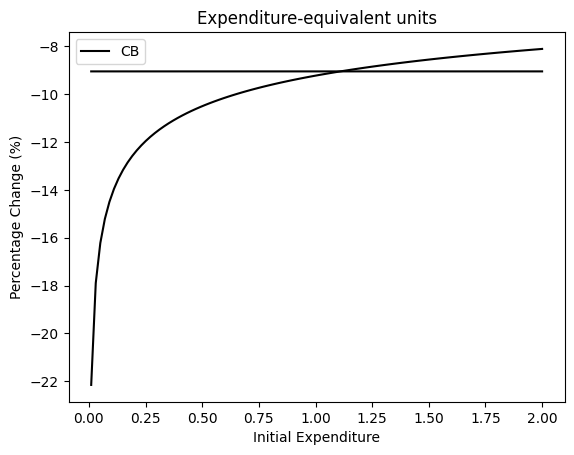

In [18]:
def compensating_variation(par, e, PT_before, PNT_before, PT_after, PNT_after):
    # Calculate baseline utility
    U0 = utility_indirect(par, e, PT=PT_before, PNT=PNT_before)
    
    # Define the function to solve for compensated expenditure
    def solve_E1(E1):
        return (1/par.epsilon) * ((E1/PNT_after)**par.epsilon - 1) - (par.nu/par.gamma) * ((PT_after/PNT_after)**par.gamma - 1) - U0
    
    # Use fsolve to find E1
    E1 = fsolve(solve_E1, e)[0]  # Start with the initial guess of e
    
    # Calculate percentage change in compensated expenditure
    pct_change = ((e -E1 ) / e) * 100  # Percentage change
    
    return E1, pct_change

# Define a range of expenditure levels
expenditure_levels = e_list #np.linspace(50, 500, 100)  # Example range of expenditure levels
PT_before = 1
PNT_before = 1
PT_after = 1.2
PNT_after = 1.0

# Initialize list to store percentage changes
compensation_pct_changes = []

# Plot the results
fig, ax = plt.subplots()#figsize=(12, 8))

# Compute percentage change in CV for each expenditure level
for e in expenditure_levels:
    _, pct_change = compensating_variation(par_bohnert, e, PT_before, PNT_before, PT_after, PNT_after)
    compensation_pct_changes.append(pct_change)

ax.plot(expenditure_levels, compensation_pct_changes, label='', c='k')

# Initialize list to store percentage changes
compensation_pct_changes = []
for e in expenditure_levels:
    _, pct_change = compensating_variation(par_cd, e, PT_before, PNT_before, PT_after, PNT_after)
    compensation_pct_changes.append(pct_change)

ax.plot(expenditure_levels, compensation_pct_changes, label='CB', c='k')

# Percentage Change in Compensation
#ax.plot(expenditure_levels, compensation_pct_changes, label='', c='k')

ax.set_xlabel('Initial Expenditure')
ax.set_ylabel('Percentage Change (%)')
ax.set_title('Expenditure-equivalent units')
ax.legend()
if new_fig: plt.savefig('Figures/compensated_expenditure.png', dpi=300, bbox_inches='tight')


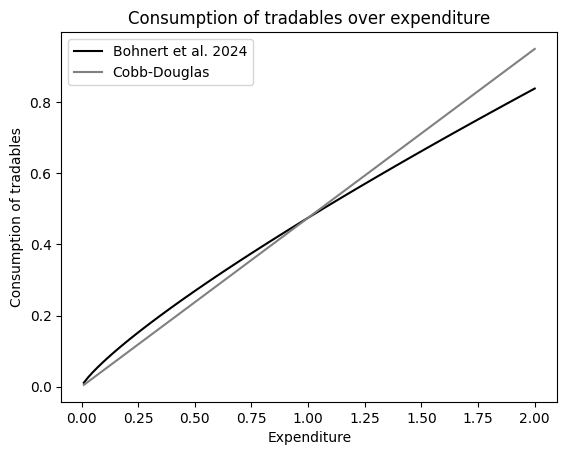

In [19]:
# consumption of tradables over expenditure
fig, ax = plt.subplots()#figsize=(12, 8))
ax.plot(e_list, calc_CT(par_bohnert, e_list), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, calc_CT(par_cd, e_list), label='Cobb-Douglas', c='grey', linestyle='-')
ax.set_xlabel('Expenditure')
ax.set_ylabel('Consumption of tradables')
ax.set_title('Consumption of tradables over expenditure')
ax.legend()


# Other stufff

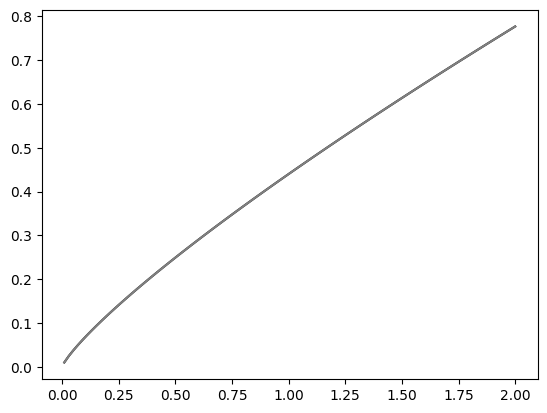

In [47]:
# Check it works 

def calc_CNT(par,e, PT=1, PNT=1):
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CNT

def calc_CNT_tilde(par, e, PT=1, PNT=1):
    e_tilde = e/PNT
    p = PT/PNT
    CNT = e_tilde*(1-par.nu*(e_tilde)**(-par.epsilon)*(p)**par.gamma)
    return CNT

def calc_CT_tilde(par, e, PT=1, PNT=1):
    e_tilde = e/PNT
    p = PT/PNT
    CT = e_tilde*p**(-1)*par.nu*(e_tilde)**(-par.epsilon)*(p)**par.gamma
    return CT


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(e_list, calc_CT_tilde(par_bohnert, e_list, PNT = 2.0), label='Bohnert et al. 2024', c='k')
ax.plot(e_list, calc_CT(par_bohnert, e_list, PNT = 2.0), label='Cobb-Douglas', c='grey', linestyle='-')

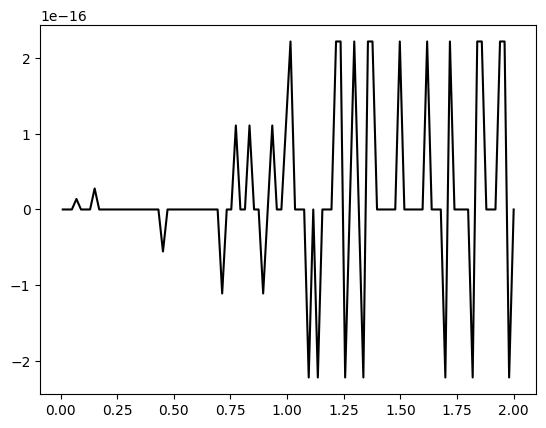

In [48]:
# Checking consumption = expenditure
fig = plt.figure()
ax = fig.add_subplot(111)

#residual = 2*calc_CT(par_bohnert, e_list, PT=2) + calc_CNT(par_bohnert, e_list,PT=2) - e_list


residual_tilde = calc_CT_tilde(par_bohnert, e_list)+ calc_CNT_tilde(par_bohnert, e_list, PT=1, PNT=1) - e_list


#residual_tilde = calc_CT_tilde(par_bohnert, e_list) + calc_CNT_tilde(par_bohnert, e_list) 

ax.plot(e_list, residual_tilde, label='Bohnert et al. 2024', c='k')

Text(0.5, 1.0, 'Inequality in Cost of living')

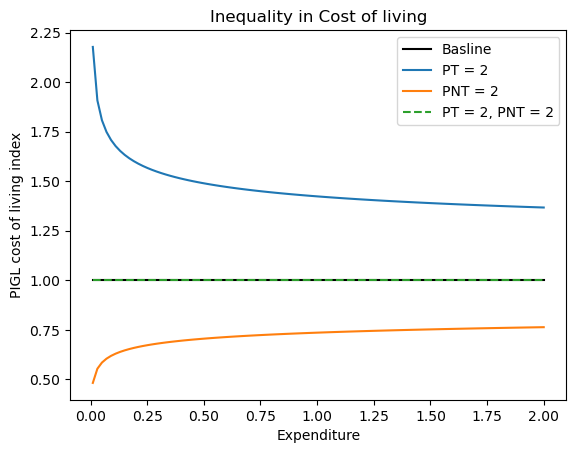

In [15]:
# *** Stort problem 

# Utility over expenditure
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list), label='Basline', c='k')
ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list, PT=2.0), label='PT = 2')
ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list, PNT=2.0), label='PNT = 2')
ax.plot(e_list, calc_cost_of_living(par_bohnert, e_list, PT=2.0, PNT=2.0), label='PT = 2, PNT = 2', linestyle='--')

ax.set_xlabel('Expenditure')
ax.set_ylabel('PIGL cost of living index')
ax.legend()
ax.set_title('Inequality in Cost of living')

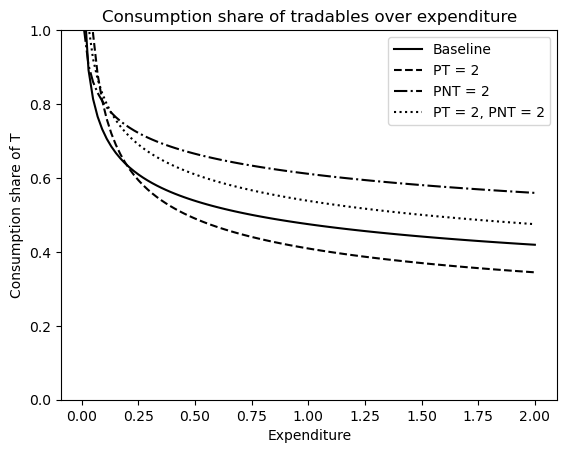

In [16]:
fig, ax = plt.subplots()#figsize=(12, 8))

# Consumption shares over expenditure
ax.plot(e_list, share_T(par_bohnert, e_list), label='Baseline', c='k')
ax.plot(e_list, share_T(par_bohnert, e_list, PT=2.0), label='PT = 2', linestyle='--', c='k')
ax.plot(e_list, share_T(par_bohnert, e_list, PNT=2.0), label='PNT = 2', linestyle='-.', c='k')
ax.plot(e_list, share_T(par_bohnert, e_list, PT=2.0, PNT=2.0), label='PT = 2, PNT = 2', linestyle=':', c='k')

ax.set_xlabel('Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Consumption share of T')
ax.set_title('Consumption share of tradables over expenditure')
ax.legend()
if new_fig: plt.savefig('Figures/consumption_share_T_over_expenditure.png', dpi=300, bbox_inches='tight')

(0.0, 1.0)

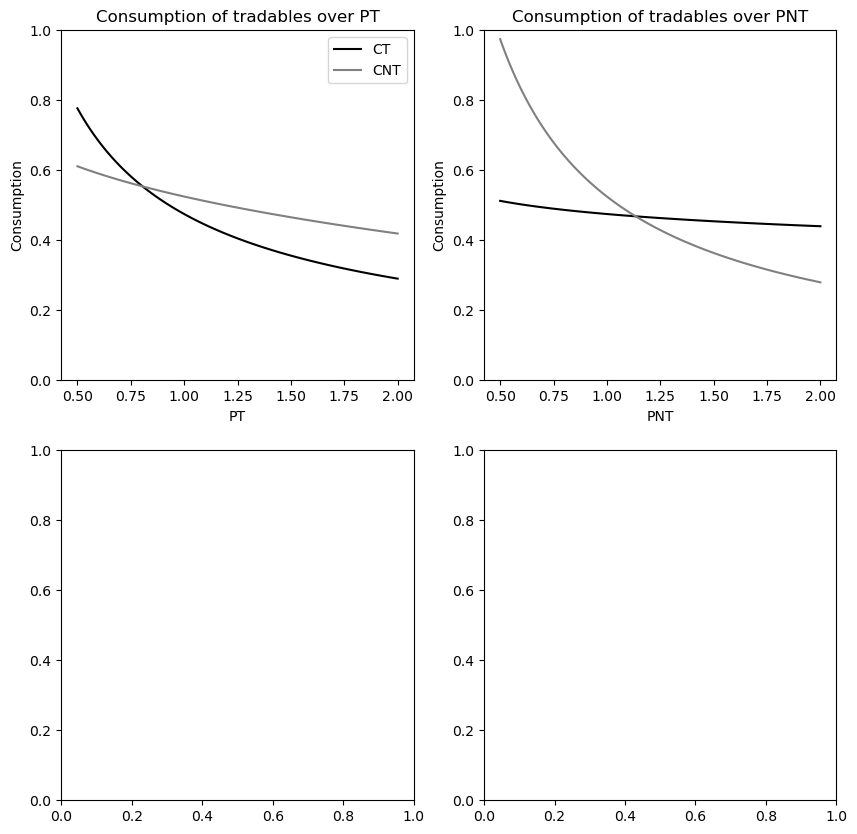

In [5]:
PT_list = np.linspace(0.5, 2.0, 100)
PNT_list = np.linspace(0.5, 2.0, 100)

# 4X 4 plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# CT over PT 
axs[0, 0].plot(PT_list, calc_CT(par_bohnert, 1, PT=PT_list), label='CT', c='k')
axs[0, 0].plot(PT_list, calc_CNT(par_bohnert, 1, PT=PT_list), label='CNT', c='grey')
axs[0, 0].set_xlabel('PT')
axs[0, 0].set_ylabel('Consumption')
axs[0, 0].set_title('Consumption of tradables over PT')
axs[0,0].set_ylim(0, 1)
axs[0, 0].legend()

# CT over PNT
axs[0, 1].plot(PNT_list, calc_CT(par_bohnert, 1, PNT=PNT_list), label='CT', c='k')
axs[0, 1].plot(PNT_list, calc_CNT(par_bohnert, 1, PNT=PNT_list), label='CNT', c='grey')
axs[0, 1].set_xlabel('PNT')
axs[0, 1].set_ylabel('Consumption')
axs[0, 1].set_title('Consumption of tradables over PNT')
axs[0,1].set_ylim(0, 1)

# Expenditure over PT
